# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [1]:
!pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
HW01.check_install(requires="0.7.1")

from tqdm import tqdm

[DONE] Install ok. Version is v0.7.1


Version v0.7.1 or above of this module is required to bypass an error in torchvision's dataset download.
If the module version does not update when you re-run the previous cell, restart the Kernel of the notebook.
If you get an error on this cell, it is probably because the module did not update: restart your notebook Kernel and try again.

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

**Note:** If you get an error with the function provided by torchvision to download PCAM, please use `HW1.PCAM(...)` instead of `datasets.PCAM(...)`. This will download the dataset from another source, but will be slower (approx. 10 minutes).

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
try:
    data_train = datasets.PCAM(root='./data', split='val', download=True, transform=transform)
    data_test = datasets.PCAM(root='./data', split='test', download=True, transform=transform)
except:
    data_train = HW01.PCAM(root='./data', split='val', download=True, transform=transform)
    data_test = HW01.PCAM(root='./data', split='test', download=True, transform=transform)

In [11]:
def plot_images_by_label(dataset, label, n=5, ):
    count = 0
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, (image, target) in enumerate(dataset):
        if target == label:
            axes[count].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC
            axes[count].axis('off')
            count += 1
            if count == n:
                break



Text(0.5, 0.75, 'Images of Tumor')

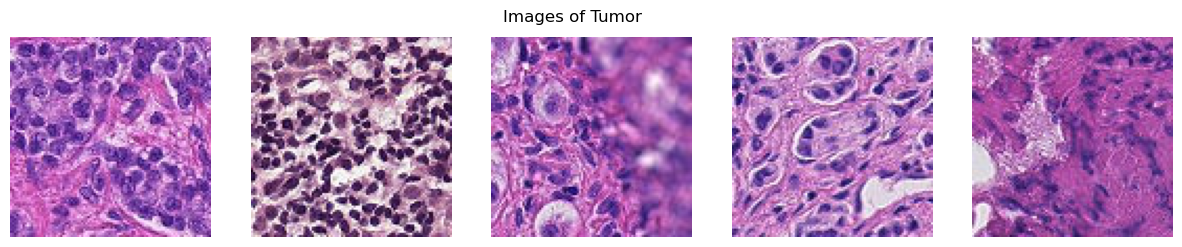

In [18]:
plot_images_by_label(data_train, label=1, n=5)
plt.suptitle("Images of Tumor", y = 0.75)

Text(0.5, 0.75, 'Images of Non Tumor')

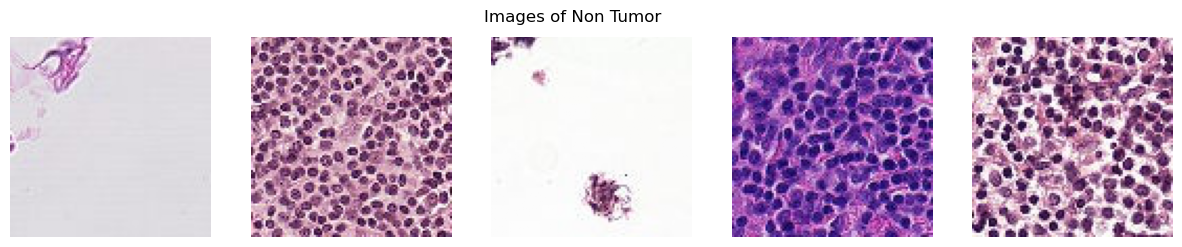

In [19]:
plot_images_by_label(data_train, label=0, n=5)
plt.suptitle("Images of Non Tumor", y = 0.75)

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [8]:
zscore_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train.transform = zscore_transform
data_test.transform = zscore_transform

In [9]:
print(f"Number of elements in training set: {len(data_train)}")
print(f"Number of elements in test set: {len(data_test)}")

# Check a sample image shape
sample_image, _ = data_train[0]
print(f"Shape of a sample image after transformation: {sample_image.shape}")


Number of elements in training set: 32768
Number of elements in test set: 32768
Shape of a sample image after transformation: torch.Size([3, 96, 96])


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [10]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [11]:
print(f"There are {len(test_loader)} minibatches in total")

There are 512 minibatches in total


## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$ and a weight decay of $10^{-1}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [23]:
def train_model(model : torch.nn.Module, dataloader : DataLoader, epochs : int):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)

    # Initialize lists to store loss and accuracy
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in tqdm(dataloader):
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / total_predictions
        epoch_accuracy = correct_predictions / total_predictions

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    # Plot the loss and accuracy
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [24]:
def test_model(model : torch.nn.Module, dataloader: DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate overall loss and accuracy
    overall_loss = running_loss / total_predictions
    overall_accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {overall_loss:.4f}")
    print(f"Test Accuracy: {overall_accuracy:.4f}")

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

100%|██████████| 512/512 [07:39<00:00,  1.11it/s]


Epoch 1/2: Loss = 1.6663, Accuracy = 0.5836


100%|██████████| 512/512 [07:40<00:00,  1.11it/s]

Epoch 2/2: Loss = 1.3803, Accuracy = 0.6266


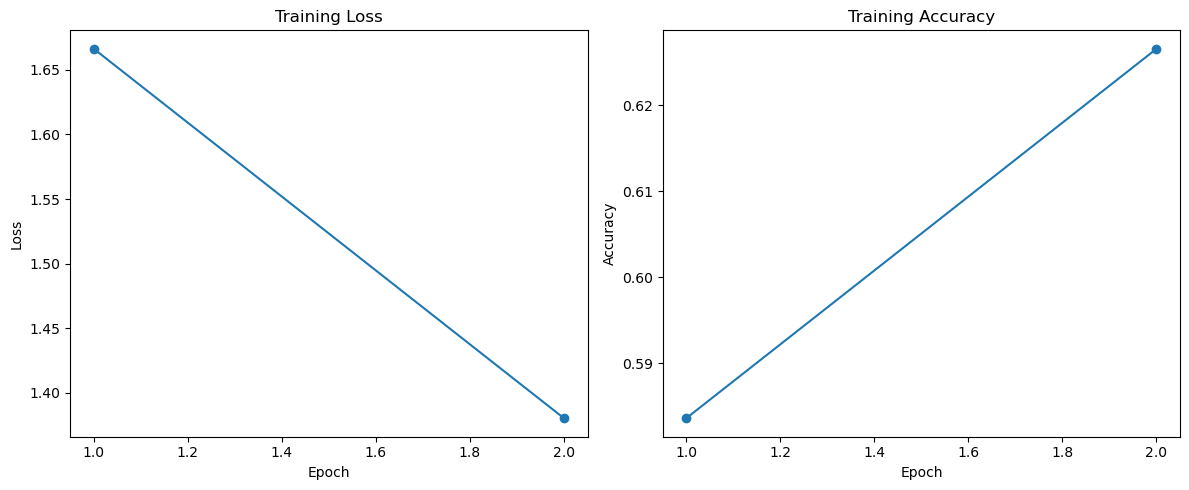

Test Loss: 1.4247
Test Accuracy: 0.6030


In [44]:
# %%time
baseline_model = torch.nn.Sequential(
    nn.Flatten(),  # Flatten the input images
    nn.Linear(3 * 96 * 96, 2)  # Linear layer with 2 output classes
)

train_model(baseline_model, train_loader, 2)
test_model(baseline_model, test_loader)

## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [13]:
import torchvision.models as models

# Load the VGG16 model pretrained on ImageNet
vgg_model = models.vgg16(weights='DEFAULT')

# Print the architecture of the VGG model
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [46]:
# Replace the last layer of the classifier with a new linear layer
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, 2)

# Freeze all layers except the last one
for param in vgg_model.features.parameters():
    param.requires_grad = False

for param in vgg_model.classifier[:-1].parameters():
    param.requires_grad = False

Now fine-tune the model by performing 2 epochs of training.

100%|██████████| 512/512 [07:46<00:00,  1.10it/s]


Epoch 1/2: Loss = 0.4758, Accuracy = 0.7749


100%|██████████| 512/512 [07:48<00:00,  1.09it/s]


Epoch 2/2: Loss = 0.4749, Accuracy = 0.7744


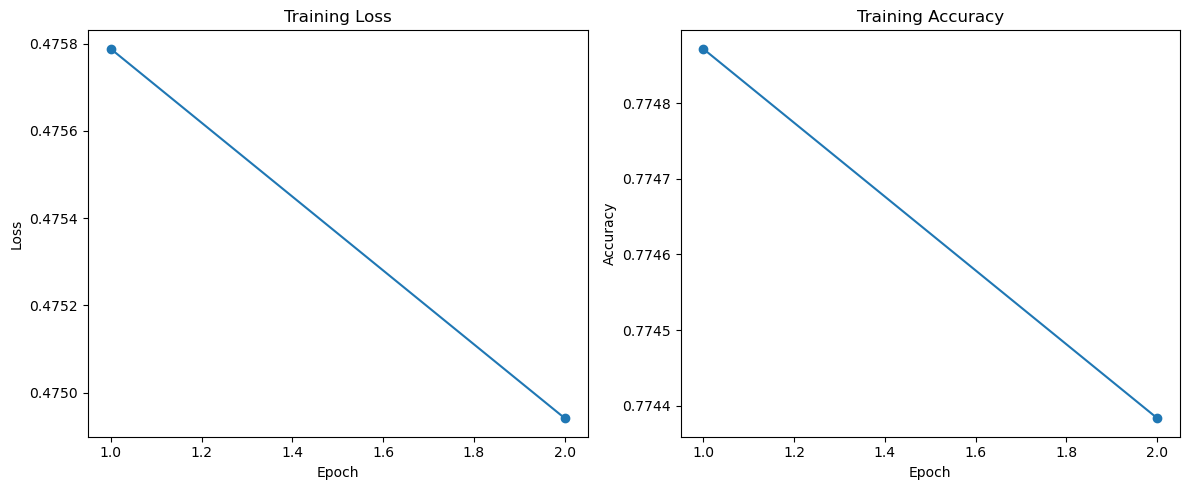

CPU times: user 1min 21s, sys: 27.8 s, total: 1min 49s
Wall time: 15min 35s


In [48]:
%%time
train_model(vgg_model, train_loader, 2)

In [49]:
test_model(vgg_model, test_loader)

Test Loss: 0.5608
Test Accuracy: 0.7527


## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [5]:
from torch.utils.data import TensorDataset

In [16]:
def precompute_model(model: torch.nn.Module, dataloader: DataLoader):
    model.to(device)
    model.eval()  

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            # Move data to the correct device
            inputs = inputs.to(device)

            # Pass data through the feature extractor part of the model
            outputs = model.features(inputs)

            # Store the outputs and labels
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all outputs and labels
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Create a TensorDataset
    precomputed_dataset = TensorDataset(all_outputs, all_labels)
    return precomputed_dataset

Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [17]:
import torchvision.models as models

# Load the VGG16 model pretrained on ImageNet
vgg_model = models.vgg16(weights='DEFAULT')

train_features =precompute_model(vgg_model, train_loader)

100%|██████████| 512/512 [07:46<00:00,  1.10it/s]


In [18]:
test_features = precompute_model(vgg_model, test_loader)

100%|██████████| 512/512 [07:43<00:00,  1.10it/s]


In [22]:
train_loader_precomputed = DataLoader(
    train_features,
    batch_size=batch_size,
    shuffle=True
)
test_loader_precomputed = DataLoader(
    test_features,
    batch_size=batch_size,
    shuffle=False
)

Finally, train a linear model on the new precomputed features for 10 epochs. Is the model better?

In [30]:
in_size = test_features[0][0].numel()

In [31]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.fc(x)

In [32]:
lin_model = LinearClassifier(in_size, 2)

100%|██████████| 512/512 [00:01<00:00, 466.49it/s]


Epoch 1/10: Loss = 0.3618, Accuracy = 0.8408


100%|██████████| 512/512 [00:00<00:00, 803.25it/s]


Epoch 2/10: Loss = 0.3240, Accuracy = 0.8619


100%|██████████| 512/512 [00:00<00:00, 836.61it/s]


Epoch 3/10: Loss = 0.3235, Accuracy = 0.8619


100%|██████████| 512/512 [00:00<00:00, 838.29it/s]


Epoch 4/10: Loss = 0.3282, Accuracy = 0.8586


100%|██████████| 512/512 [00:00<00:00, 838.57it/s]


Epoch 5/10: Loss = 0.3175, Accuracy = 0.8631


100%|██████████| 512/512 [00:00<00:00, 834.81it/s]


Epoch 6/10: Loss = 0.3247, Accuracy = 0.8608


100%|██████████| 512/512 [00:00<00:00, 836.48it/s]


Epoch 7/10: Loss = 0.3205, Accuracy = 0.8631


100%|██████████| 512/512 [00:00<00:00, 837.13it/s]


Epoch 8/10: Loss = 0.3225, Accuracy = 0.8617


100%|██████████| 512/512 [00:00<00:00, 835.51it/s]


Epoch 9/10: Loss = 0.3169, Accuracy = 0.8646


100%|██████████| 512/512 [00:00<00:00, 834.34it/s]


Epoch 10/10: Loss = 0.3154, Accuracy = 0.8651


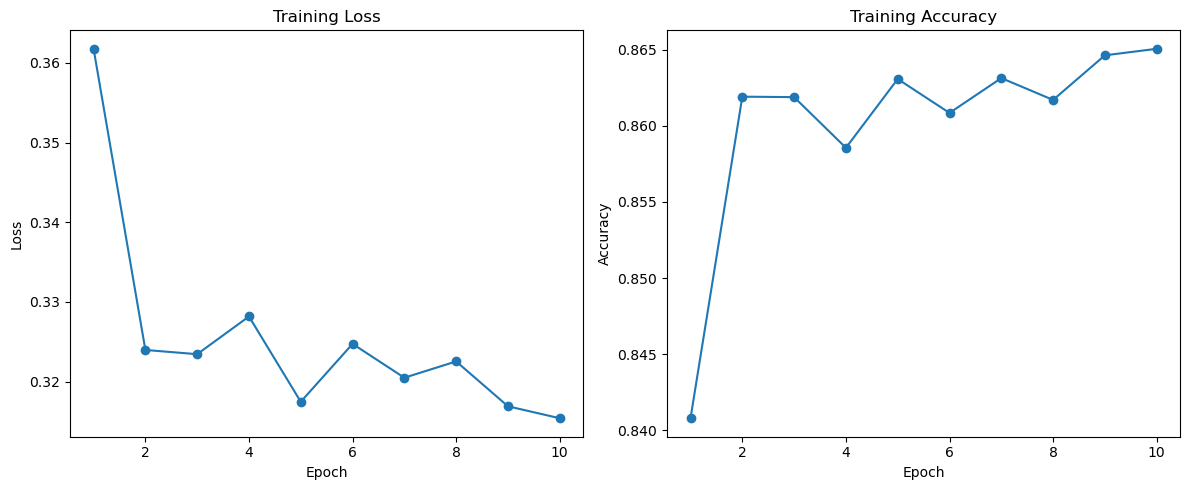

In [33]:

train_model(lin_model,train_loader_precomputed, 10)

In [34]:
test_model(lin_model, test_loader_precomputed)

Test Loss: 0.6063
Test Accuracy: 0.7787


The test accuracy is higher since we are training our model in a larger number of epochs